In [214]:
import os
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn,draw_box

import math

import cv2

### Load data

In [215]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [216]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

In [217]:
unlabeled_scene_index = np.arange(106)
labeled_scene_index = np.arange(106, 134)

In [218]:
transform = torchvision.transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [219]:
sample, target, road_image, extra = iter(trainloader).next()
e_id = 0
example = sample[e_id]
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


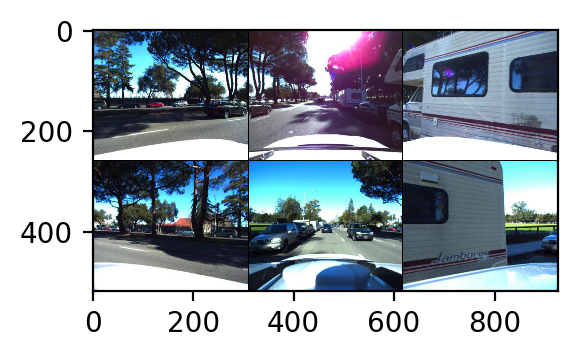

In [230]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))

### BEV class

In [220]:
class BEV:
    
    def __init__(self, image):
    
        self.image = image
        self.angle = [-30, -90, -150, 30, 90, 150]
        self.dst_h,self.dst_w = 400,560
        
    def bev_transform(self, x1=271, x2=289, crop_h = 140, dst_h=400, dst_w = 560):
        '''
        dst_h: destination image height
        dst_w: destination image height
        crop_h: crop height for ROI
        x1,x2: destination image correspongding points
        '''
        image = self.image
        
        H,W = image.shape[:2]

        #source image points
        src = np.float32([[0, H], [W, H], [0, 0], [W, 0]]) 
        #corresponding points in destination image
        dst = np.float32([[x1, self.dst_h], [x2, dst_h], [0, 0], [dst_w, 0]])
        M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

        image = image[crop_h:H, 0:W] # Apply np slicing for ROI crop

        self.warped = cv2.warpPerspective(image, M, (dst_w, dst_h)) # Image warping: transform to bird eye view
        img = self.warped
        n_h,n_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], dtype=np.uint8)       
        points = np.array([[[x1+10, n_h], [x2-10, n_h], 
                            [515,0],[55, 0]]]) #make 60 degree angle crop

        # points = np.array([[[lower_left_x,lower_left_y],[lower_right_x,lower_right_y],
        #                   [upper_left_x,upper_left_y],[upper_right_x,upper_right_y]]])

        cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)
        self.warped_img = cv2.bitwise_and(img,img,mask = mask)
        
        return self.warped_img
    
    def whole_view(self, c_x=465, c_y = 465):
        
        warped_img = self.warped_img
        h,w = warped_img.shape[:2]
        self.whole_img = np.zeros((c_y*2,c_x*2,3))
        self.whole_img[c_y-h:c_x,c_y-w//2:c_y+w//2] = warped_img
        
        return self.whole_img
    
    def rotateImage(self, angle):
        image = self.whole_img
        dst_image = image.copy()
        (h, w) = image.shape[:2]
        (c_x, c_y) = (w // 2, h // 2)

        transl = np.array((2, 3))

        rotation_matrix = cv2.getRotationMatrix2D((c_x, c_y), angle, 1.0 )
        img_rotation = cv2.warpAffine(image, rotation_matrix, (w,h)) 

        return img_rotation



### Example transforming bev image

In [221]:
image_set = [sample[0][i].numpy().transpose(1, 2, 0) for i in range(len(sample[0]))]

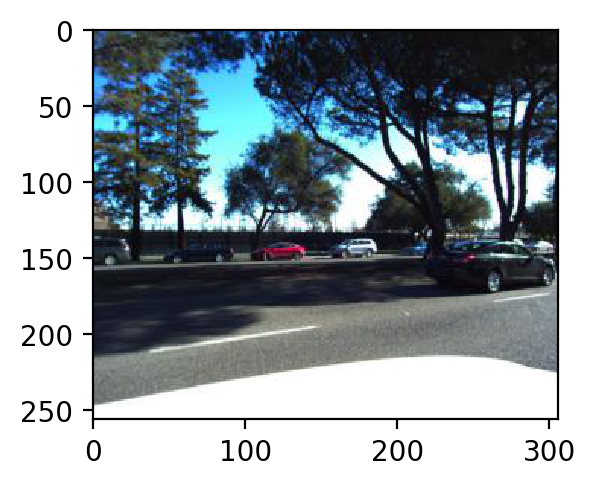

In [222]:
plt.imshow(image_set[0])

In [223]:
def bev_overview(image_list):
    for i,img in enumerate(image_list):
        bev = BEV(img)
        warped_img = bev.bev_transform() # transform single image to bev
        whole_img = bev.whole_view() # put bev segment into whole view
        rotated_img = bev.rotateImage(bev.angle[i]) # rotate by corresponding camera angle
        if i == 0:
            bev_img = rotated_img
        else:
            bev_img += rotated_img
    m,n = 400,400
    h,w = bev_img.shape[:2]
    cut_h,cut_w = (h-2*m)//2,(w-2*n)//2
    bev_img = bev_img[cut_h:cut_h+2*m,cut_w:cut_w+2*n]
    return bev_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


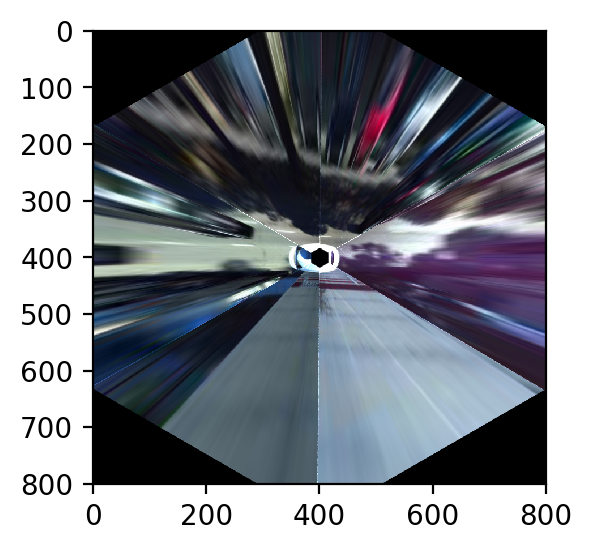

In [224]:
bev_img = bev_overview(image_set)
plt.imshow(bev_img)

### Draw bounding boxes on bev

In [225]:
def draw_box_bev(ax, bounding_box, color):
    bbox = bounding_box.values.flatten().tolist()
    p1 = (bbox[0],bbox[1])
    p2 = (bbox[0]+bbox[2],bbox[1])
    p3 = (bbox[0]+bbox[2],bbox[1]+bbox[3])
    p4 = (bbox[0],bbox[1]+bbox[3])
    point_sequence = np.array([p1,p2,p3,p4,p1])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_sequence.T[0], point_sequence.T[1], color=color)


In [226]:
anno = pd.read_csv('data/annotation_newfeat_3.csv')
bbox_s = anno[anno['scene']==106][anno['sample']==0][['bev_x','bev_y','bev_box_width','bev_box_height']]

/Users/CallMeXiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


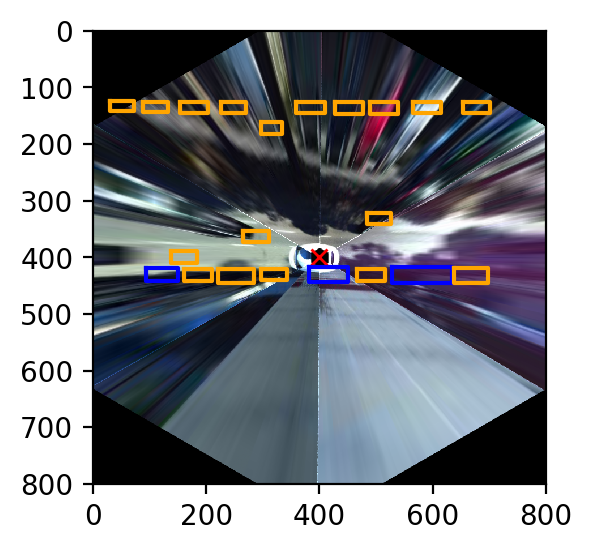

In [227]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(bev_img, cmap ='binary');
h,w = bev_img.shape[:2]
# The ego car position

ax.plot(w//2, h//2, 'x', color="red")

for i in range(bbox_s.shape[0]):
    # You can check the implementation of the draw box to understand how it works 
    draw_box_bev(ax, bbox_s.iloc[i], color=color_list[target[0]['category'][i]])    

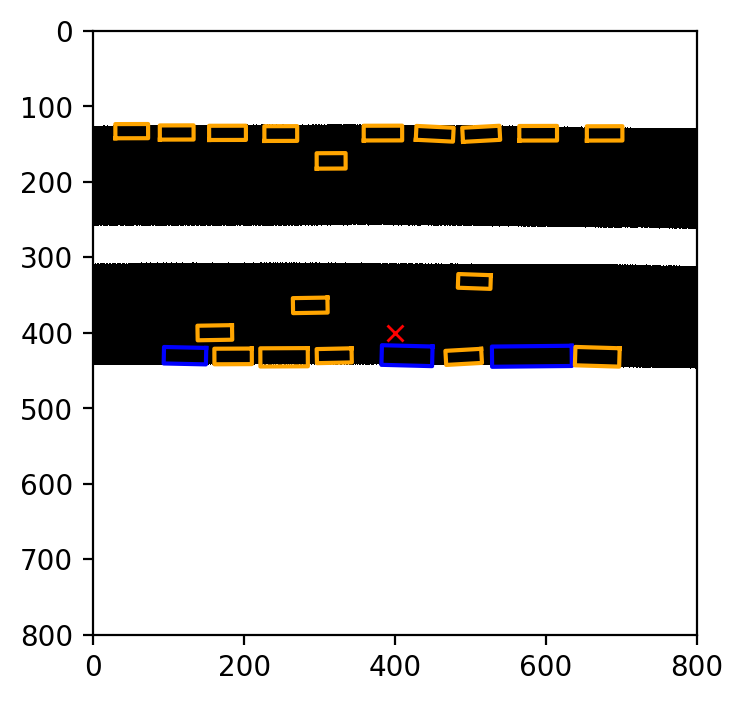

In [101]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    